In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
from dataclasses import dataclass
from collections import namedtuple, defaultdict
from tasks.markov import *
from models.base_models import *
from models.pos_encoder import *
from tasks.test_markov import *
from config import *
from train import *
import figures.plot as plot
from util import *
import seaborn as sns
import torch.utils.benchmark as benchmark
from tqdm.notebook import tqdm, trange

from figures.head_view import *

torch.set_printoptions(precision=3, sci_mode=False)

%load_ext autoreload
%autoreload 2

In [29]:
# For comments, see TriggerMorkov.ipynb
def run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, total_trans, alpha, pos_enc="rotary", mlp_layer=None, epochs=10000, num_layers=2):

    flash = False
    
    if pos_enc in ["rotary", "abs"]:
        flash = True

    if mlp_layer is None:
        mlp_layer = num_layers - 1
        
    mlp = [False] * num_layers
    if mlp_layer < num_layers:
        mlp[mlp_layer] = True 
    mlp = tuple(mlp)
    print(mlp)
    
    config = Config(
            emb_dim=16,
            num_layers=num_layers,
            num_heads=tuple([1]*num_layers),
            identity_query=False,
            seq_len=SEQ_LEN,
            vocab_size=VOC_SIZE,
            batch_size=BATCH_SIZE,
            num_epochs=epochs,
            eval_iter=1000,
            pos_enc=pos_enc,
            pos_max_len=SEQ_LEN,
            get_attn=500,
            get_checkpoints=1500,
            mlp=mlp,
            activation=mlp,
            flash=flash, # Use rotary
            ff_dim=16,
            layer_norm=False,
            ngram=2,
            learning_rate=1e-4,
            task_name="latent"
        )

    sampler_config = LatentMarkovSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, total_trans=total_trans,
                                               batch_size=BATCH_SIZE, task_name="latent")
    
    model = Transformer(config)
    model = model.to(config.device)

    train_results = train_model_with_plot(model, config, sampler_config, show=True)

    return train_results, model

(False, True)
Max size:  16000


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/16000 [00:00<?, ?it/s]

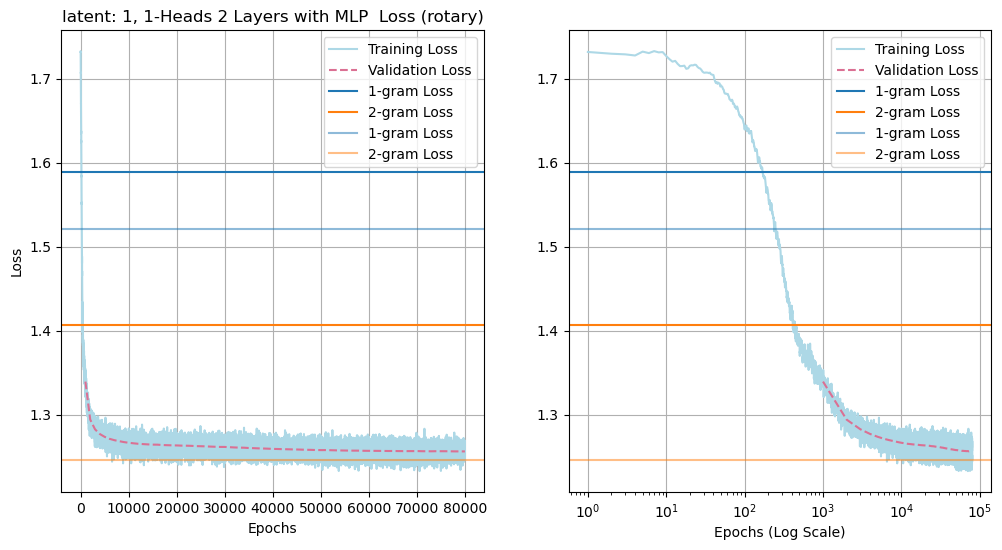

Creating images:   0%|          | 0/81 [00:00<?, ?it/s]

Creating images:   0%|          | 0/81 [00:00<?, ?it/s]

,


<IPython.core.display.Javascript object>

In [30]:
SEQ_LEN, VOC_SIZE, BATCH_SIZE = 128, 5, 64
total_trans = 2
alpha = 0.1
train_results, model = run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, total_trans, alpha, pos_enc="rotary", mlp_layer=None, epochs=80000, num_layers=2)

In [31]:
sampler = train_results["sampler"]
OV1 = model.layers[0].MHA.value.weight.T @ model.layers[0].MHA.out.weight.T
OV2 = model.layers[1].MHA.value.weight.T @ model.layers[1].MHA.out.weight.T

In [32]:
range_toks = model.embed(torch.arange(VOC_SIZE, device="cuda"))
range_toks[1]

tensor([ 0.109, -0.766,  0.221, -1.142, -1.634, -0.935,  1.334,  0.416, -0.841,
        -0.907, -1.083,  0.015,  0.969,  0.849, -0.552, -0.472],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [7]:
zero_context = range_toks @ (OV1 + OV2 + OV1@OV2)
zero_context[1]

tensor([-0.027, -0.611, -0.487, -0.045, -0.661, -1.517,  0.092, -0.307,  0.128,
         0.683, -1.012,  0.400, -0.114,  0.606,  0.349, -0.204, -0.059,  0.103,
        -0.499, -0.114, -0.655, -0.135, -0.355, -1.119,  0.762,  1.661,  0.762,
        -0.519, -0.887, -0.041, -0.254, -1.178, -0.586,  1.473,  1.810,  0.104,
         1.399, -0.011, -1.578,  0.898,  0.505,  0.365, -0.031,  0.240,  0.468,
        -0.668, -1.132, -0.248,  0.535,  0.593, -1.291,  1.041,  0.176,  0.598,
         0.776, -1.612,  0.872, -0.524,  0.548, -0.600,  0.303,  0.015,  0.489,
         1.053], device='cuda:0', grad_fn=<SelectBackward0>)

In [8]:
F.cosine_similarity(zero_context.unsqueeze(1), range_toks.unsqueeze(0), dim=-1)

tensor([[-0.101, -0.014, -0.110,  ..., -0.087, -0.006, -0.017],
        [-0.225, -0.006,  0.065,  ...,  0.002, -0.112,  0.261],
        [ 0.075, -0.060, -0.425,  ...,  0.083,  0.000,  0.076],
        ...,
        [-0.070, -0.135, -0.106,  ..., -0.364, -0.153,  0.044],
        [-0.106,  0.018, -0.014,  ...,  0.122, -0.236,  0.260],
        [ 0.171, -0.081, -0.162,  ..., -0.132,  0.079, -0.147]],
       device='cuda:0', grad_fn=<SumBackward1>)

In [142]:
range_toks @ OV1@OV2

tensor([[ 0.680,  0.160, -0.863, -0.309, -0.170, -1.736,  1.273, -0.947, -0.427,
         -0.104, -0.154, -0.411, -0.980, -0.068, -0.989,  0.179,  0.187,  1.397,
         -0.073, -0.337,  0.294,  0.050, -0.136,  0.769, -0.183, -0.165, -0.186,
         -0.667,  0.337,  0.163,  0.219,  0.655],
        [ 0.609,  1.404,  1.930,  1.576,  0.196,  5.068, -9.617, -1.436,  0.936,
         -3.452,  4.128, -1.736,  6.251,  2.295,  1.250,  6.593,  2.302, -4.938,
         -4.089,  1.149, -0.067,  1.432,  3.712, -3.572,  0.942,  0.451,  1.068,
         -0.376, -0.152, -3.390,  3.162, -6.947],
        [ 0.340,  0.066, -0.179,  0.091, -0.662,  0.455, -0.856, -0.053, -0.130,
         -0.412,  0.039, -0.378,  0.262,  0.286, -0.022,  0.295,  0.864, -0.108,
         -0.593,  0.031,  0.134,  0.054, -0.045, -0.503,  0.024,  0.232,  0.210,
         -0.059, -0.025,  0.075, -0.165, -0.207],
        [-1.081, -0.373, -0.595, -0.330,  0.505, -2.139,  3.660,  0.641, -0.447,
          1.524, -1.477,  1.205, -3.287,

In [33]:
batch0, _ = sampler.test(latent=0)
toks = model.embed(batch0)
toks1 = model.layers[0](toks)[0]
toks2 = toks1 + model.layers[1].MHA(toks1, False)[0]
static_info = toks + toks @ (OV1 + OV2 + OV1@OV2) 
context0 = toks2 - static_info

Latent variable:  0


In [34]:
batch1, _ = sampler.test(latent=1)
toks = model.embed(batch1)
toks1 = model.layers[0](toks)[0]
toks2 = toks1 + model.layers[1].MHA(toks1, False)[0]
static_info = toks + toks @ (OV1 + OV2 + OV1@OV2) 
context1 = toks2 - static_info

Latent variable:  1


In [35]:
sampler.trans_matrix

tensor([[[0.096, 0.117, 0.047, 0.414, 0.326],
         [0.170, 0.005, 0.770, 0.045, 0.010],
         [0.192, 0.128, 0.360, 0.305, 0.015],
         [0.129, 0.072, 0.173, 0.169, 0.456],
         [0.186, 0.175, 0.390, 0.079, 0.170]],

        [[0.472, 0.114, 0.058, 0.317, 0.040],
         [0.028, 0.733, 0.040, 0.157, 0.042],
         [0.327, 0.077, 0.519, 0.022, 0.055],
         [0.539, 0.015, 0.090, 0.175, 0.181],
         [0.244, 0.200, 0.054, 0.403, 0.099]]], device='cuda:0')

In [36]:
batch0

tensor([[3, 3, 4, 2, 2, 2, 2, 2, 0, 3, 2, 1, 3, 3, 4, 0, 0, 4, 3, 4, 2, 2, 2, 3,
         3, 2, 2, 3, 4, 0, 4, 0, 0, 4, 2, 3, 4, 2, 0, 0, 0, 4, 2, 4, 0, 3, 2, 2,
         2, 0, 4, 2, 2, 2, 3, 4, 3, 3, 4, 0, 0, 4, 1, 2, 2, 3, 2, 3, 4, 1, 2, 2,
         1, 2, 2, 0, 0, 3, 4, 0, 1, 2, 3, 4, 2, 0, 4, 2, 3, 2, 2, 2, 2, 3, 4, 2,
         4, 0, 3, 4, 3, 0, 3, 3, 3, 0, 4, 1, 2, 2, 0, 3, 0, 4, 0, 4, 2, 2, 3, 2,
         1, 2, 0, 4, 1, 2, 3, 4]], device='cuda:0')

In [37]:
tok = 4
context0[batch0==tok]

tensor([[     0.018,      0.027,     -0.010,      0.012,      0.019,     -0.025,
              0.048,      0.014,     -0.003,     -0.018,     -0.008,      0.035,
             -0.018,      0.003,     -0.006,      0.011],
        [    -2.949,      0.994,      0.188,     -0.224,      1.819,      0.906,
              0.537,     -1.100,     -0.074,      1.304,     -0.199,     -0.691,
             -1.826,     -0.222,     -0.028,      0.387],
        [    -1.906,      0.524,     -0.076,     -0.384,      1.043,      0.959,
              0.348,     -0.532,     -0.198,      0.690,      0.056,     -0.223,
             -1.015,     -0.161,     -0.167,      0.348],
        [    -1.774,      0.464,      0.010,     -0.291,      0.969,      0.785,
              0.281,     -0.543,     -0.134,      0.679,     -0.019,     -0.285,
             -0.975,     -0.173,     -0.109,      0.285],
        [    -3.250,      0.834,      0.292,     -0.383,      1.861,      1.101,
              0.493,     -1.178,     -0

In [39]:
tok = 0
mlp_out = model.layers[1].mlp(static_info)
probs = nn.Softmax(dim=-1)(model.output_layer(static_info + mlp_out))[batch1==tok].mean(dim=0)
target = (sampler.trans_matrix[0][tok] + sampler.trans_matrix[1][tok]) / 2
F.kl_div(target.log(), probs, reduction="sum")

tensor(0.100, device='cuda:0', grad_fn=<SumBackward0>)

In [41]:
tok = 0
context_tok1 = context1[batch1==tok][1:4].mean(dim=0)
context_tok0 = context0[batch0==tok][1:4].mean(dim=0)
context_tok = context_tok0
probs = nn.Softmax(dim=-1)(model.output_layer(static_info + context_tok + model.layers[1].mlp(static_info + context_tok)))[batch1==tok].mean(dim=0)
target = sampler.trans_matrix[0][tok]
F.kl_div(target.log(), probs, reduction="sum")

tensor(0.008, device='cuda:0', grad_fn=<SumBackward0>)

In [27]:
tok = 3
context_tok = context0[batch0==tok][-5:].mean(dim=0)
probs = nn.Softmax(dim=-1)(model.output_layer(static_info + context_tok + model.layers[1].mlp(static_info + context_tok)))[batch1==tok].mean(dim=0)
target = sampler.trans_matrix[0][tok]
F.kl_div(target.log(), probs, reduction="sum")

tensor(0.433, device='cuda:0', grad_fn=<SumBackward0>)

In [77]:
context[batch==tok][-5:].mean(dim=0).norm()

tensor(29.885, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [78]:
(static_info[batch==tok].mean(dim=0) + context[batch==tok][-5:].mean(dim=0)).norm()

tensor(8.415, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [54]:
model.output_layer(static_info)[batch==tok].mean(dim=0)

tensor([ 1.171, -2.532, -0.187,  0.118,  0.506], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [57]:
model.output_layer(static_info + model.layers[1].mlp(static_info))[batch==tok].mean(dim=0)

tensor([ 0.654,  0.464,  0.366, -0.915, -0.524], device='cuda:0',
       grad_fn=<MeanBackward1>)

In [36]:
nn.ReLU()(static_info[batch==tok].mean(dim=0) @ model.layers[1].mlp[0].weight.T + model.layers[1].mlp[0].bias)

tensor([0.000, 3.193, 5.850, 2.812, 0.000, 0.000, 0.000, 0.463, 4.527, 0.000,
        0.000, 0.000, 1.955, 0.000, 0.258, 2.246, 0.056, 0.000, 2.499, 0.000,
        1.007, 0.569, 4.376, 0.000, 2.014, 0.582, 0.000, 0.000, 0.000, 2.687,
        3.812, 2.058], device='cuda:0', grad_fn=<ReluBackward0>)

In [38]:
# latent 0
nn.ReLU()((context_tok + static_info[batch==tok].mean(dim=0)) @ model.layers[1].mlp[0].weight.T + model.layers[1].mlp[0].bias)

tensor([0.091, 3.599, 6.372, 3.893, 0.000, 0.000, 0.000, 0.000, 6.385, 0.000,
        0.000, 0.000, 1.325, 0.000, 0.000, 3.501, 0.000, 0.000, 3.296, 0.000,
        0.391, 0.000, 5.277, 0.000, 2.100, 1.794, 0.000, 0.000, 0.000, 4.170,
        5.574, 0.000], device='cuda:0', grad_fn=<ReluBackward0>)

In [52]:
# latent 1
nn.ReLU()((context_tok + static_info[batch==tok].mean(dim=0)) @ model.layers[1].mlp[0].weight.T + model.layers[1].mlp[0].bias)

tensor([0.000, 1.984, 0.000, 1.822, 0.000, 3.143, 4.114, 2.869, 0.000, 0.000,
        3.853, 3.414, 0.493, 0.000, 0.000, 0.000, 1.111, 0.558, 0.124, 4.741,
        3.380, 0.000, 0.000, 0.000, 1.888, 0.000, 2.387, 0.000, 1.388, 0.000,
        0.000, 2.951], device='cuda:0', grad_fn=<ReluBackward0>)

In [83]:
batch, _ = sampler.modified(0, 1, 0)

Latent variable:  0


In [84]:
nn.Softmax(dim=-1)(model(batch)[0])[batch==0]

tensor([[0.204, 0.153, 0.349, 0.142, 0.152],
        [0.219, 0.135, 0.351, 0.131, 0.164],
        [0.179, 0.174, 0.334, 0.168, 0.144],
        [0.200, 0.160, 0.339, 0.152, 0.150],
        [0.196, 0.167, 0.333, 0.157, 0.147],
        [0.086, 0.271, 0.296, 0.246, 0.100],
        [0.130, 0.220, 0.324, 0.206, 0.120],
        [0.098, 0.257, 0.307, 0.231, 0.107],
        [0.068, 0.289, 0.278, 0.271, 0.094],
        [0.068, 0.291, 0.286, 0.257, 0.098],
        [0.062, 0.293, 0.282, 0.267, 0.096],
        [0.058, 0.301, 0.277, 0.268, 0.096],
        [0.056, 0.296, 0.291, 0.260, 0.096],
        [0.067, 0.290, 0.300, 0.246, 0.098]], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [85]:
sampler.trans_matrix

tensor([[[0.065, 0.300, 0.271, 0.277, 0.087],
         [0.021, 0.272, 0.080, 0.401, 0.225],
         [0.157, 0.070, 0.106, 0.233, 0.433],
         [0.155, 0.107, 0.324, 0.280, 0.134],
         [0.137, 0.158, 0.385, 0.089, 0.230]],

        [[0.235, 0.130, 0.340, 0.126, 0.170],
         [0.109, 0.182, 0.158, 0.541, 0.010],
         [0.094, 0.103, 0.455, 0.121, 0.227],
         [0.054, 0.433, 0.124, 0.317, 0.072],
         [0.082, 0.092, 0.502, 0.074, 0.251]],

        [[0.026, 0.257, 0.021, 0.384, 0.312],
         [0.168, 0.053, 0.105, 0.621, 0.053],
         [0.016, 0.010, 0.588, 0.062, 0.324],
         [0.109, 0.167, 0.276, 0.353, 0.094],
         [0.100, 0.025, 0.243, 0.607, 0.025]]], device='cuda:0')

In [77]:
tok = 0
context_tok = context[batch==tok][-5:].mean(dim=0)
probs = nn.Softmax(dim=-1)(model.output_layer(static_info + context_tok + model.layers[1].mlp(static_info+context_tok)))[batch==tok].mean(dim=0)
target = sampler.trans_matrix[0][tok]
F.kl_div(target.log(), probs, reduction="sum")

tensor(0.002, device='cuda:0', grad_fn=<SumBackward0>)

In [58]:
tok = 4
context_other = context[batch==2][-5:].mean(dim=0)
probs = nn.Softmax(dim=-1)(model.output_layer(static_info + context_other + model.layers[1].mlp(static_info + context_other)))[batch==tok].mean(dim=0)
target = sampler.trans_matrix[0][tok]
F.kl_div(target.log(), probs, reduction="sum")

tensor(0.157, device='cuda:0', grad_fn=<SumBackward0>)

In [48]:
F.kl_div(sampler.trans_matrix[0][0].log(), nn.Softmax(dim=-1)(model(batch)[0])[batch==0], reduction="none").sum(dim=-1)

tensor([0.055, 0.003, 0.002, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.003,
        0.003, 0.003, 0.002, 0.002], device='cuda:0', grad_fn=<SumBackward1>)

In [51]:
tok = 3
F.kl_div(sampler.trans_matrix[0][tok].log(), nn.Softmax(dim=-1)(model(batch)[0])[batch==tok], reduction="none").sum(dim=-1)

tensor([0.018, 0.016, 0.014, 0.001, 0.002, 0.001, 0.001, 0.004, 0.002, 0.002,
        0.002, 0.003, 0.001, 0.001, 0.003, 0.002, 0.002, 0.002, 0.002, 0.004,
        0.002, 0.002, 0.002, 0.002, 0.002, 0.003, 0.002, 0.002, 0.002],
       device='cuda:0', grad_fn=<SumBackward1>)

In [67]:
nn.Softmax(dim=-1)(model.output_layer(toks2+toks1 + model.layers[1].mlp(toks1 + toks2)))[batch == 1]

tensor([[0.369, 0.085, 0.108, 0.188, 0.250],
        [0.373, 0.080, 0.112, 0.185, 0.250],
        [0.380, 0.084, 0.110, 0.181, 0.246],
        [0.377, 0.082, 0.108, 0.180, 0.253],
        [0.375, 0.082, 0.111, 0.186, 0.247],
        [0.376, 0.083, 0.108, 0.184, 0.250],
        [0.375, 0.081, 0.110, 0.186, 0.247],
        [0.373, 0.082, 0.108, 0.185, 0.252],
        [0.374, 0.081, 0.111, 0.186, 0.248],
        [0.373, 0.083, 0.107, 0.185, 0.252],
        [0.368, 0.078, 0.111, 0.186, 0.258],
        [0.371, 0.083, 0.108, 0.185, 0.253],
        [0.373, 0.084, 0.107, 0.184, 0.252],
        [0.369, 0.080, 0.109, 0.184, 0.258],
        [0.372, 0.082, 0.110, 0.186, 0.250],
        [0.373, 0.079, 0.110, 0.182, 0.257],
        [0.373, 0.082, 0.107, 0.184, 0.254],
        [0.373, 0.082, 0.107, 0.184, 0.254],
        [0.374, 0.082, 0.106, 0.184, 0.254],
        [0.374, 0.080, 0.109, 0.181, 0.256],
        [0.373, 0.079, 0.109, 0.181, 0.257],
        [0.385, 0.082, 0.102, 0.179, 0.253],
        [0

In [230]:
OV_2 = model.layers[1].MHA.value.weight.T @ model.layers[1].MHA.out.weight.T
range_toks = torch.arange(VOC_SIZE)
toks = model.embed(range_toks)
toks @ OV_2 @ model.output_layer.weight.T

tensor([[    -0.143,      0.211,     -1.574,      1.501,     -0.153,      0.371,
             -1.002,      0.245,     -2.099,      0.211],
        [    -0.483,     -0.131,     -0.712,      0.938,     -0.559,      0.263,
             -0.664,      0.135,     -1.029,      0.262],
        [     0.320,      0.328,     -0.718,     -0.371,      0.575,     -0.193,
              0.590,      0.120,      0.341,     -0.794],
        [     0.177,      0.512,     -1.156,      0.781,      0.334,      0.082,
             -0.295,     -0.029,     -1.034,     -0.393],
        [     0.501,     -2.059,      7.036,     -7.117,     -2.408,     -1.739,
              4.708,     -0.300,     10.424,      1.103],
        [     0.578,     -1.332,      5.385,     -5.406,     -1.666,     -1.336,
              3.919,     -0.344,      8.064,      0.662],
        [    -0.192,      1.318,     -4.612,      4.412,      1.263,      0.853,
             -2.934,      0.441,     -6.396,     -0.460],
        [     1.052,     -0

In [227]:
OV_1 = model.layers[0].MHA.value.weight.T @ model.layers[0].MHA.out.weight.T
torch.norm(OV_1, dim=-1)

tensor([0.344, 0.465, 0.363, 0.323, 0.351, 0.439, 0.350, 0.446, 0.350, 0.341,
        0.427, 0.315, 0.399, 0.335, 0.368, 0.393, 0.375, 0.377, 0.410, 0.417,
        0.318, 0.364, 0.336, 0.288, 0.310, 0.355, 0.431, 0.366, 0.409, 0.371,
        0.449, 0.394, 0.427, 0.389, 0.318, 0.368, 0.327, 0.378, 0.381, 0.354,
        0.346, 0.367, 0.357, 0.301, 0.395, 0.374, 0.379, 0.287, 0.460, 0.298,
        0.335, 0.382, 0.440, 0.438, 0.340, 0.355, 0.411, 0.384, 0.377, 0.325,
        0.425, 0.368, 0.381, 0.358, 0.369, 0.413, 0.383, 0.343, 0.365, 0.366,
        0.381, 0.349, 0.359, 0.298, 0.374, 0.424, 0.369, 0.365, 0.294, 0.349,
        0.322, 0.401, 0.464, 0.343, 0.363, 0.356, 0.367, 0.332, 0.388, 0.336,
        0.363, 0.345, 0.371, 0.376, 0.349, 0.377, 0.310, 0.315, 0.370, 0.410,
        0.402, 0.410, 0.473, 0.354, 0.390, 0.392, 0.369, 0.348, 0.390, 0.348,
        0.420, 0.377, 0.390, 0.326, 0.380, 0.401, 0.346, 0.347, 0.438, 0.337,
        0.334, 0.371, 0.367, 0.322, 0.401, 0.328, 0.384, 0.410],

In [6]:
sampler = train_results["sampler"]

In [6]:
batch, prob = sampler.test()

Latent variable:  0


In [57]:
batch

tensor([[3, 3, 5, 1, 5, 3, 2, 3, 3, 2, 3, 6, 8, 2, 4, 6, 3, 4, 0, 2, 7, 5, 1, 3,
         4, 0, 9, 3, 2, 4, 7, 8, 2, 5, 5, 8, 8, 8, 7, 0, 8, 0, 9, 1, 7, 8, 4, 0,
         7, 4, 4, 4, 0, 9, 7, 2, 2, 2, 7, 0, 9, 7, 8, 0, 0, 0, 1, 3, 6, 0, 3, 6,
         9, 9, 7, 8, 0, 7, 0, 6, 8, 9, 7, 4, 6, 5, 6, 9, 4, 6, 5, 1, 9, 6, 5, 9,
         2, 4, 8, 2, 7, 6, 5, 9, 7, 2, 4, 0, 1, 3, 0, 6, 0, 6, 4, 9, 7, 2, 5, 0,
         1, 2, 3, 8, 2, 0, 0, 7]])

In [216]:
tok1 = 6
tok2 = 8
# (6,8) appears much more often in 0 than 1
probe = torch.tensor([[tok1, tok2]*(SEQ_LEN//2)])
tok = 9
probe[0,60] = tok
logits = model(probe)[0][0]

In [217]:
(nn.Softmax(dim=1)(logits)[probe[0]==tok] - sampler.trans_matrix[0][tok].unsqueeze(0)).abs().sum(dim=-1).detach()

tensor([0.212])

In [218]:
(nn.Softmax(dim=1)(logits)[probe[0]==tok] - sampler.trans_matrix[1][tok].unsqueeze(0)).abs().sum(dim=-1).detach()

tensor([0.815])

In [173]:
sampler.trans_matrix[1][tok, tok2], sampler.trans_matrix[1][tok2, tok]

(tensor(0.170), tensor(0.083))

In [174]:
sampler.trans_matrix[0][tok, tok2], sampler.trans_matrix[0][tok2, tok]

(tensor(0.009), tensor(0.422))

In [7]:
ratio10 = (sampler.trans_matrix[1] / sampler.trans_matrix[0])
ratio01 = (sampler.trans_matrix[0] / sampler.trans_matrix[1])

In [18]:
ratio10[4,3], ratio01[4,3]

(tensor(0.625, device='cuda:0'), tensor(1.599, device='cuda:0'))